In [1]:
# https://www.learnpytorch.io/01_pytorch_workflow/

In [2]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cpu'

### Data (preparing and loading)

In [4]:
# create know parameters
weight = 0.7
bias = 0.3

# create data
start =0
end =1
step =0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)

y= weight * X + bias



In [5]:
X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

Note: When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn on training data and then evaluate it on test data to get an indication of how well it generalizes to unseen examples.

### Split data into training and test sets

In [6]:
train_split = int(0.8 *len(X))

In [7]:
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [8]:
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

### visualization

In [9]:
def plot_predictions(train_data=X_train,
                     train_labels = y_train,
                     test_data=X_test,
                     test_labels= y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10,7))
  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});


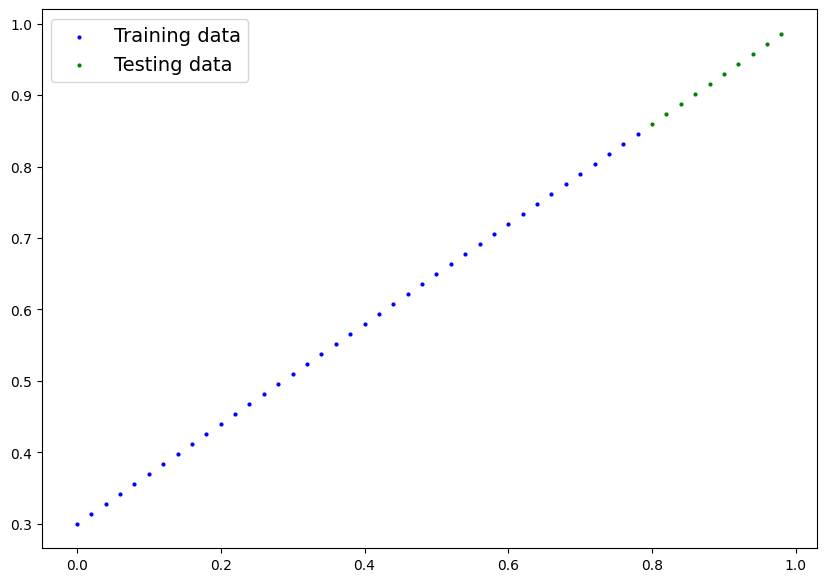

In [10]:
plot_predictions()

## Build Model

In [11]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.rand(1, # <- start with random weights (this will get adjusted as the model learns)
                                   dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

    self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

  def  forward(self, x: torch.Tensor)-> torch.Tensor:# <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)


### Checking the contents of a PyTorch model

In [12]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([-0.6382], requires_grad=True)]

In [13]:
# List named parameters
model.state_dict()

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([-0.6382]))])

### Making predictions using torch.inference_mode()

In [14]:
# make predictions with model

with torch.inference_mode():
  y_preds = model(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

You probably noticed we used torch.inference_mode() as a context manager (that's what the with torch.inference_mode(): is) to make the predictions.

As the name suggests, torch.inference_mode() is used when using a model for inference (making predictions).

torch.inference_mode() turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the forward() method) faster.

Note: In older PyTorch code, you may also see torch.no_grad() being used for inference. While torch.inference_mode() and torch.no_grad() do similar things, torch.inference_mode() is newer, potentially faster and preferred.

In [15]:
# check the predictions
print(f"Number of testing samples:{len(X_test)}")
print(f"Number of predictions made : {len(y_preds)}")
print(f"predicted values:{y_preds}")

Number of testing samples:10
Number of predictions made : 10
predicted values:tensor([[0.0677],
        [0.0853],
        [0.1030],
        [0.1206],
        [0.1382],
        [0.1559],
        [0.1735],
        [0.1912],
        [0.2088],
        [0.2265]])


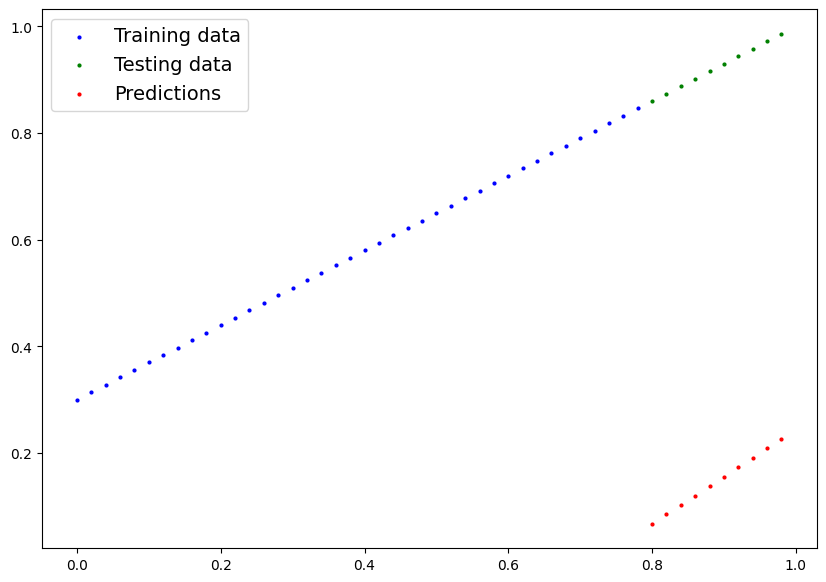

In [16]:
plot_predictions(predictions=y_preds)

### Train model

In [17]:
# create loss function
loss_fn = nn.L1Loss() #MAE

# create optimizer
optimizer = torch.optim.SGD(
    params= model.parameters(), # parameters of target model to optimize
    lr=0.01 # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))
)

### PyTorch training loop

In [18]:
torch.manual_seed(42)

# set the number of epochs
epochs = 100

#create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range (epochs):
  model.train()
  y_pred = model(X_train)
  loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  model.eval()

  with torch.inference_mode():
    test_pred = model(X_test)
    test_loss = loss_fn(test_pred, y_test.type(torch.float))


    if epoch%10 == 0:
      epoch_count.append(epoch)
      train_loss_values.append(loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.8670692443847656 | MAE Test Loss: 0.7624635696411133 
Epoch: 10 | MAE Train Loss: 0.7518593072891235 | MAE Test Loss: 0.6277537941932678 
Epoch: 20 | MAE Train Loss: 0.636649489402771 | MAE Test Loss: 0.4930438995361328 
Epoch: 30 | MAE Train Loss: 0.5214395523071289 | MAE Test Loss: 0.3583340346813202 
Epoch: 40 | MAE Train Loss: 0.4062294363975525 | MAE Test Loss: 0.2236236333847046 
Epoch: 50 | MAE Train Loss: 0.2910192012786865 | MAE Test Loss: 0.08891315013170242 
Epoch: 60 | MAE Train Loss: 0.17580902576446533 | MAE Test Loss: 0.04579734057188034 
Epoch: 70 | MAE Train Loss: 0.11110417544841766 | MAE Test Loss: 0.13382463157176971 
Epoch: 80 | MAE Train Loss: 0.09491372108459473 | MAE Test Loss: 0.16986632347106934 
Epoch: 90 | MAE Train Loss: 0.08829215168952942 | MAE Test Loss: 0.18401066958904266 


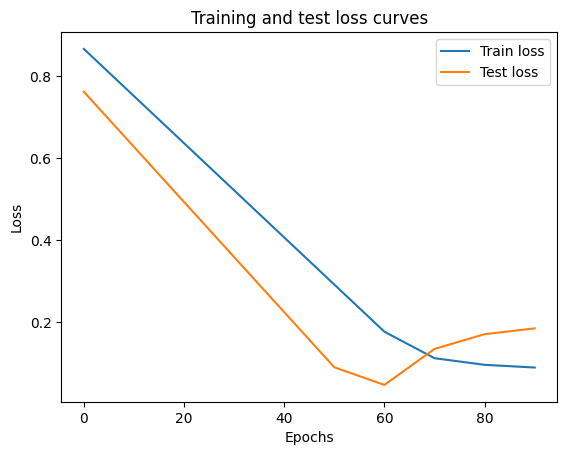

In [19]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [20]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([1.1143])), ('bias', tensor([0.1178]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [21]:
# 1. Set the model in evaluation mode
model.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model(X_test)
y_preds

tensor([[1.0093],
        [1.0315],
        [1.0538],
        [1.0761],
        [1.0984],
        [1.1207],
        [1.1430],
        [1.1653],
        [1.1875],
        [1.2098]])

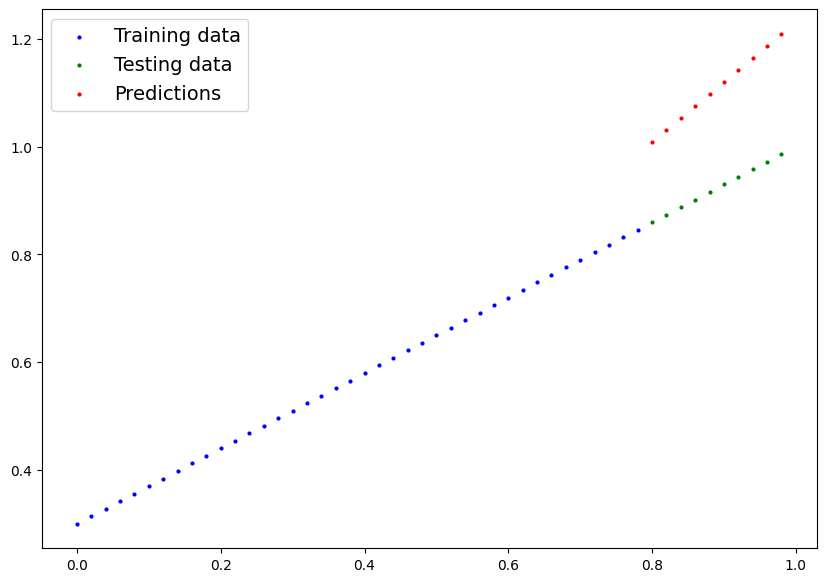

In [22]:
plot_predictions(predictions=y_preds)